<a href="https://colab.research.google.com/github/amilkh/cs230-fer/blob/transfer-learning/fer2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
# turker

%matplotlib inline

In [3]:
print(tf.__version__)

1.15.0


In [4]:
pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-dutcdtda
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-dutcdtda
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=b5985796f488531510e487c8a6842fdaab82ec036070ea78babfa642a5852318
  Stored in directory: /tmp/pip-ephem-wheel-cache-rrw4auqw/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [4]:
from keras_vggface.vggface import VGGFace

Using TensorFlow backend.


In [5]:
pip show keras-vggface

Name: keras-vggface
Version: 0.6
Summary: VGGFace implementation with Keras framework
Home-page: https://github.com/rcmalli/keras-vggface
Author: Refik Can MALLI
Author-email: mallir@itu.edu.tr
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: pillow, pyyaml, keras, six, numpy, h5py, scipy
Required-by: 


In [7]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/cs230 project/collab/fer2013/fer2013.csv')

#print('Number of samples in the dataset: ', data.shape[0])
# Transform images from strings to lists of integers. TODO: use an array cast
data['pixels'] = data['pixels'].apply(lambda x: [int(pixel) for pixel in x.split()])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
emotion_cat = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

# See the target distribution (check for imbalance)
#target_counts = data['emotion'].value_counts().reset_index(drop=False)
#target_counts.columns = ['emotion', 'number_samples']
#target_counts['emotion'] = target_counts['emotion'].map(emotion_cat)
#target_counts

# Select randomly 10 images
#random_seed = 1
#data_sample = data.sample(10, random_state=random_seed)
#f, axarr = plt.subplots(2, 5, figsize=(20, 10))

#i, j = 0, 0
#for idx, row in data_sample.iterrows():
#    img = np.array(row['pixels']).reshape(48,48)
#    axarr[i,j].imshow(img, cmap='gray')
#    axarr[i,j].set_title(emotion_cat[row['emotion']])
#    if j==4:
#        i += 1
#        j = 0
#    else:
#        j += 1

In [0]:
#from skimage import data, color
from skimage.transform import rescale, resize

In [0]:
data_train = data[data['Usage']=='Training']
#print('Number samples in the training dataset: ', data_train.shape[0])

data_dev = data[data['Usage']=='PublicTest']
#print('Number samples in the development dataset: ', data_dev.shape[0])

# Retrieve train input and target
X_train, y_train = data_train['pixels'].tolist(), data_train['emotion'].values
#print(len(X_train))
#print(X_train[0])
# Reshape images to 4D (num_samples, width, height, num_channels)
X_train = np.array(X_train, dtype='float32').reshape(-1,48,48,1)
# Normalize images with max (the maximum pixel intensity is 255)
X_train = X_train/255.0
#print(X_train.shape)
#print(X_train[0])
#image_resized = resize(image, (image.shape[0] // 4, image.shape[1] // 4), anti_aliasing=True)

# Retrieve dev input and target
X_dev, y_dev = data_dev['pixels'].tolist(), data_dev['emotion'].values
X_dev = np.array(X_dev, dtype='float32').reshape(-1,48,48,1)
X_dev = X_dev/255.0

In [0]:
pixelsize = 224
X_dev_res = np.zeros((X_dev.shape[0], pixelsize,pixelsize,3))
for ind in range(X_dev.shape[0]):  #X_dev.shape[0]
  sample = X_dev[ind]
  sample = sample.reshape(48, 48)
  #plt.imshow(sample, cmap='gray')
  #plt.show()
  image_resized = resize(sample, (pixelsize, pixelsize), anti_aliasing=True)
  X_dev_res[ind,:,:,:] = image_resized.reshape(pixelsize,pixelsize,1)


In [0]:
X_train_res = np.zeros((X_train.shape[0], pixelsize,pixelsize,3))
for ind in range(X_train.shape[0]):  #X_dev.shape[0]
  sample = X_train[ind]
  sample = sample.reshape(48, 48)
  #plt.imshow(sample, cmap='gray')
  #plt.show()
  image_resized = resize(sample, (pixelsize, pixelsize), anti_aliasing=True)
  X_train_res[ind,:,:,:] = image_resized.reshape(pixelsize,pixelsize,1)

In [1]:
print ("X_train shape: " + str(X_train.shape))
print ("X_train_res shape: " + str(X_train_res.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_dev shape: " + str(X_dev.shape))
print ("X_dev_res shape: " + str(X_dev_res.shape))
print ("Y_dev shape: " + str(y_dev.shape))

NameError: ignored

In [0]:
i = 10
image = X_train[i,:,:,:].reshape(48, 48)
plt.imshow(image, cmap='gray')
plt.show()

image_resized = X_train_res[i,:,:,1].reshape(pixelsize, pixelsize)
plt.imshow(image_resized, cmap='gray')
plt.show()


In [0]:
print(sample.shape)
print(image_resized.shape)

In [0]:
#Baseline model
model = tf.keras.models.Sequential([
    InputLayer(input_shape=(48,48,1),name="input"),
    Conv2D(filters=32,kernel_size=3,activation='relu',padding='same',name="conv1"),
    Dropout(0.25), BatchNormalization(),
    Conv2D(filters=32,kernel_size=3,activation='relu',padding='same',name="conv2"),
    Dropout(0.25), BatchNormalization(),
    MaxPool2D(pool_size=(2,2),name="maxpool1"),
    Conv2D(filters=64,kernel_size=3,activation='relu',padding='same',name="conv3"),
    Dropout(0.25), BatchNormalization(),
    Conv2D(filters=64,kernel_size=3,activation='relu',padding='same',name="conv4"),
    Dropout(0.25), BatchNormalization(),
    Flatten(),
    Dense(1024,input_shape=(24*24*64,1),activation='relu',name='fc1'),
    Dense(7,input_shape=(1024,1),activation='softmax',name='fc-softmax')
])

print("Accuracy after training")
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
model.fit(X_train,y_train,batch_size=32,epochs=1,validation_data=(X_dev, y_dev))

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace
#from constants import *
from keras.utils import plot_model
import keras
from sklearn.metrics import *
from keras.engine import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D


[+] Building CNN
94699520/94694792 [==============================] - 1s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7f1c6f258470> [0]
<keras.layers.convolutional.Conv2D object at 0x7f1c6f2584e0> [1]
<keras.layers.normalization.BatchNormalization object at 0x7f1c6f258748> [2]
<keras.layers.core.Activation object at 0x7f1c6f258eb8> [3]
<keras.layers.pooling.MaxPooling2D object at 0x7f1c6f258ef0> [4]
<keras.layers.convolutional.Conv2D object at 0x7f1c6f1f9e10> [5]
<keras.layers.normalization.BatchNormalization object at 0x7f1c6f2214a8> [6]
<keras.layers.core.Activation object at 0x7f1c6f221da0> [7]
<keras.layers.convolutional.Conv2D object at 0x7f1c6f221f28> [8]
<keras.layers.normalization.BatchNormalization object at 0x7f1c6f1d7fd0> [9]
<keras.layers.core.Activation object at 0x7f1c6f1e0668> [10]
<keras.layers.convolutional.Conv2D object at 0x7f1c6f168c50> [11]
<keras.layers.convolutional.Conv2D object at 0x7f1c6f19e940> [12]
<keras.layers.normalization.BatchNormalization 

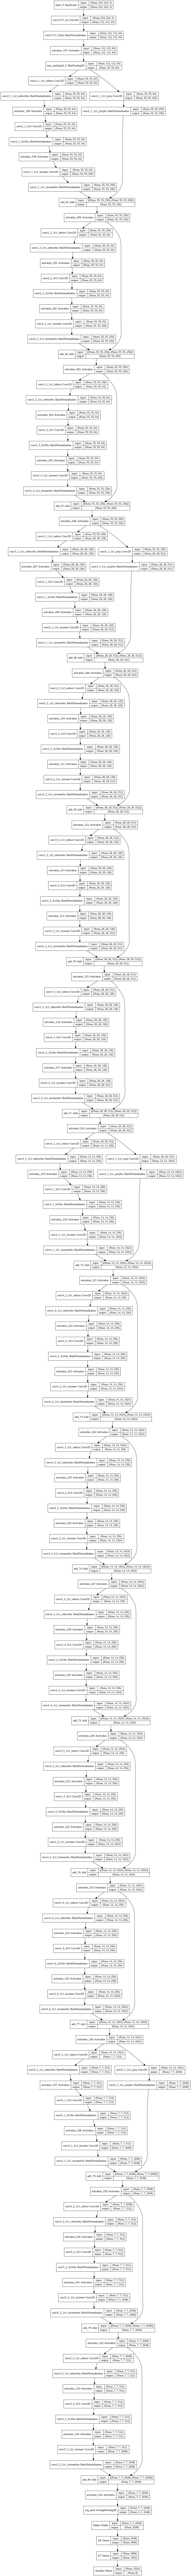

In [11]:
print('[+] Building CNN')

vgg_notop = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
last_layer = vgg_notop.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dense(1024, activation='relu', name='fc7')(x)
#print("Emotions count", len(EMOTIONS))
l=0
for layer in vgg_notop.layers:
  print(layer,"["+str(l)+"]")
  l=l+1
for i in range(101):
  vgg_notop.layers[i].trainable = False

out = Dense(7, activation='softmax', name='classifier')(x)

custom_resnet = Model(vgg_notop.input, out)


optim = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
#optim = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

custom_resnet.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
plot_model(custom_resnet, to_file='model2.png', show_shapes=True)

In [0]:
custom_resnet.fit(X_train_res,y_train,batch_size=32,epochs=1,validation_data=(X_dev_res, y_dev))

In [2]:
30000*224*224*3

4515840000